Run this code to get all the necessary functions to visualize and process data


In [1]:
run AnyRatioAnalysis_SZ.py

{'140': {'15N/UnSub': {'WeightedRVal': 0.041879759336026376, 'WeightedStDev': 0.002595339122785597, 'WeightedStError': 0.0003826618771488432, 'RelStError': 0.009137155590568654, 'ShotNoiseLimit by Quadrature': 0.003703908845710369}, '13C/UnSub': {'WeightedRVal': 0.0033925723055591057, 'WeightedStDev': 0.00031134539028575807, 'WeightedStError': 4.590537338354208e-05, 'RelStError': 0.01353114075367562, 'ShotNoiseLimit by Quadrature': 0.012746708586949764}, '13C/15N': {'WeightedRVal': 0.08138749988185112, 'WeightedStDev': 0.009682461596626292, 'WeightedStError': 0.001427601078201249, 'RelStError': 0.017540790419581308, 'ShotNoiseLimit by Quadrature': 0.013232652336056949}}, '138': {'15N/UnSub': {'WeightedRVal': 0.0033286839872438954, 'WeightedStDev': 0.0006095361219397303, 'WeightedStError': 4.505820667530089e-05, 'RelStError': 0.013536342544973297, 'ShotNoiseLimit by Quadrature': 0.012046801064562965}, '13C/UnSub': {'WeightedRVal': 0.04151570869191641, 'WeightedStDev': 0.0025056002879737

Define the input file and the list of isotopes you extracted in order, as they were extracted from FTStatistic. 

By default, the code will compute ratio for every combination; here 13C/15N, 13C/UnSub, and 15N/UnSub. If you don't care about some of those (i.e. 13C/15N), you should add that ration and its inverse to omitRatios. In this case, you could write omitRatios = ['13C/15N','15N/13C']. 

In [2]:
inputStandardFile = "AA_std_2_04.xlsx"
isotopeList = ['UnSub','15N','13C']
gc_elution_on = True
peakTimeFrames = [(5.65,5.85), (5.65,5.85), (9.74,10.04), (10.00,10.30), (13.74,14.04)]
omitRatios = ['15N/13C']

Import the data into a workable form

In [3]:
peaks = _importPeaksFromFTStatFile(inputStandardFile)

In [4]:
pandas = _convertToPandasDataFrame(peaks)

The FTStat import has each peak (single line of FTStat input code, i.e. a 13C or 15N peak) as a separate dataframe. This code combines these so that each fragment (where a fragment is a set of peaks, i.e. the 109 fragment as a 13C, 15N, and Unsubstituted peak) has a single dataframe. It then culls scans that fall outside of some threshold, i.e. here with TIC * IT more than three standard deviations from the mean. Note the isotopeList input is the same as defined in input 2; the same isotopeList is used in multiple functions and should be carried through the entire script, so it is easiest to change it once at the start. 

In [52]:
Merged = _combineSubstituted(pandas, None, gc_elution_on, peakTimeFrames, 2, isotopeList, 0.10, outputPath)

This plots a number of data quality metrics related to the AGC system, determining how TIC, IT, and TIC * IT vary with retention time and with each other. (Note: not sure how this applies to separate parts of the GC, especially once it is culled for each fragment). It also prints the standard deviation of each. (good <0.05-0.07; ok < 0.10; bad >0.10)

**You can change the df=Merged[x] line in order to look at the data quality of each fragment**

You may want to change to scatter plots; in the ax.plot line, change ax.plot to ax.scatter. 

TIC Mean and STD
6.17e+09
1.57
IT Mean and STD
2.66e-01
0.76
TIC*IT Mean and STD
4.84e+05
1.07


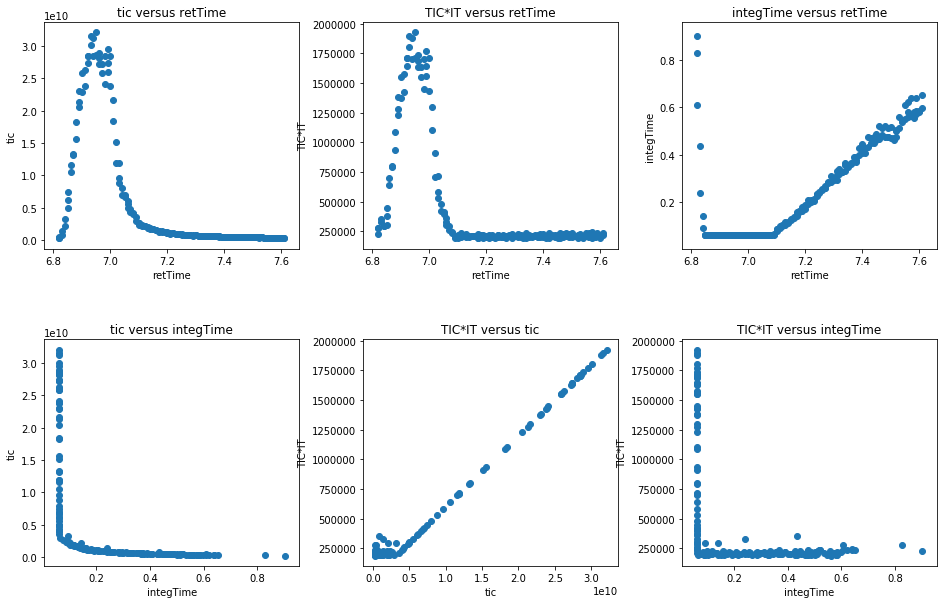

In [5]:
#Intiialize figure
fig = plt.figure(figsize=(16, 10))

#Initializes an outer grid. Sets of subplots for each peak will be placed into this outer grid. 
numberOfPeaks = 5
outer_grid = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)

#What do you want to look at?
df = Merged[1] #change the index to look at the fragment of interest

#The base case gives the tic plots for the whole measurement, then the loop plots each fragment
for i in range(numberOfPeaks):
    if i == 0:
        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 3,
            subplot_spec=outer_grid[i], wspace=0.25, hspace=0.40)

        plotlist = [('retTime','tic'),('retTime','TIC*IT'),('retTime','integTime'),('integTime','tic'),('tic','TIC*IT'),('integTime','TIC*IT')]

        for item in plotlist:
            ax = plt.Subplot(fig, inner_grid[plotlist.index(item)])
            ax.scatter(df[item[0]].tolist(),df[item[1]].tolist())
            ax.set_xlabel(item[0])
            ax.set_ylabel(item[1])
            ax.set_title(item[1] + ' versus ' + item[0])
            fig.add_subplot(ax)

    else:
        pass
print('TIC Mean and STD')
print('{:.2e}'.format(df['tic'].mean()))
print(round(df['tic'].std()/df['tic'].mean(),2))
print('IT Mean and STD')
print('{:.2e}'.format(df['integTime'].mean()))
print(round(df['integTime'].std()/df['integTime'].mean(),2))
print('TIC*IT Mean and STD')
print('{:.2e}'.format(df['TIC*IT'].mean()))
print(round(df['TIC*IT'].std()/df['TIC*IT'].mean(),2))


Another metric for data quality; this bins ratios as a function of retention time and the AGC variables (TIC, IT, etc.) and sees how they vary. Binning makes systematic variations more clear due to the large number of data. I haven't discovered clear "good/bad" characteristics for this data; in the long run we probably want to output a single number for each of these and compare to some target. But this may be useful for now. 

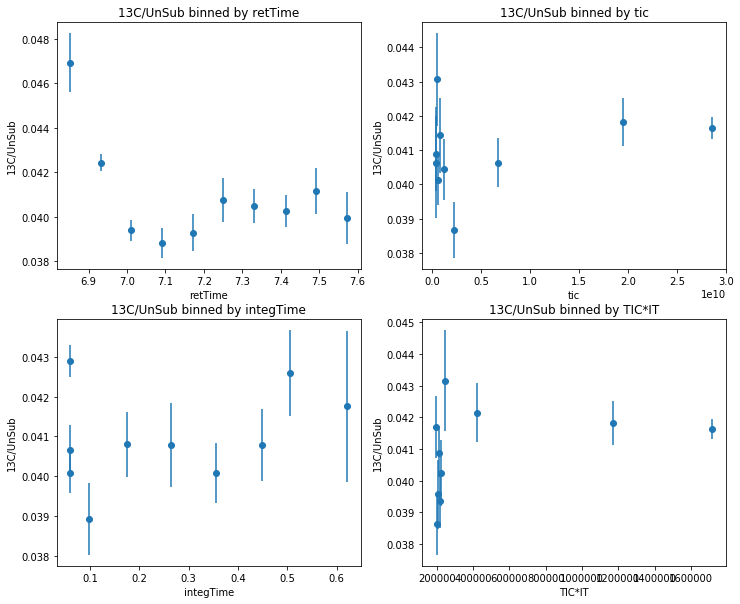

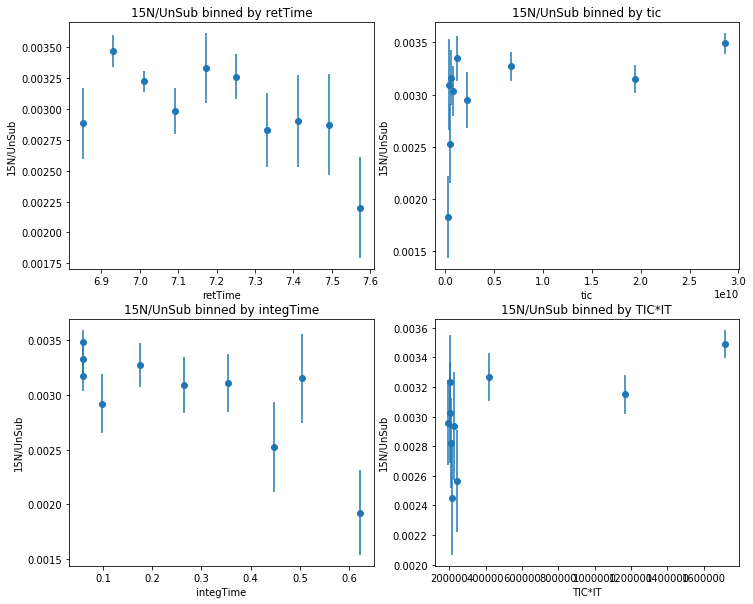

In [6]:
df = Merged[1]
numBins = 10    
xvars = ['retTime','tic','integTime','TIC*IT']
count = df.shape[0]/10

#N.B: I use the name specialIsotopeList to avoid overwriting the isotopeList variable the rest of the code uses. 
#One could avoid this by making this a separate function, but I mess with this code often enough (and it takes
#a while to import large excel sheets for many fragment measurements) so I leave it by itself here. This may be 
#a little confusing, and should be resolved whenever we figure out the best way to reduce variation based on 
#TIC*IT to a single number saying "good" or "bad", which is the ultimate goal. 

specialIsotopeList = ['13C','15N']
for isotope in specialIsotopeList:
    
    fig = plt.figure(figsize=(12,10))
    
    for variable in xvars:

        avgXList = []
        avgYList = []
        errorList = []

        for div in range(0,numBins):

            if isotope + '/UnSub' in df:
                targetVariable = isotope + '/UnSub'
            else:
                targetVariable = 'UnSub/' + isotope

            sortDf = df.sort_values(by=[variable])
            division = [int(div * count//1),int((div+1)*count//1)]
            restrictDf = sortDf.iloc[list(range(division[0],division[1]))]
            Ymean = np.mean(restrictDf[targetVariable])
            YStd = np.std(restrictDf[targetVariable])
            YStError = YStd / np.power(len(restrictDf),0.5)
            Xmean = np.mean(restrictDf[variable])

            avgXList.append(Xmean)
            avgYList.append(Ymean)
            errorList.append(YStError)

        plt.subplot(2,2,xvars.index(variable)+1)
        plt.errorbar(avgXList, avgYList, errorList, fmt='o')
        plt.xlabel(variable)
        plt.ylabel(targetVariable)
        plt.title(targetVariable + ' binned by ' + variable)

    plt.show()

Calculates the output ratios, errors, shot noise limits, etc. 

In [8]:
output = _calcRawFileOutput(Merged, gc_elution_on, isotopeList, omitRatios)

15N/13C
15N/13C
15N/13C
15N/13C


Plots the output into an easily visualizeable form. This may not be necessary if one only extracts a single fragment. You may need to mess with the numCols, widthMultiple, and heightMultiple variables (increasing the latter two makes the figure wider or taller) to make the figure appear nice for different numbers of plots. 

KeyError: 'Ratio'

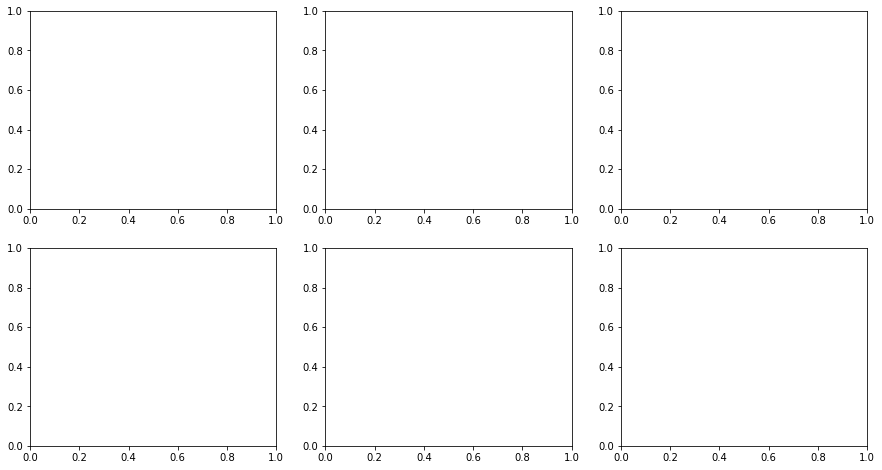

In [9]:
_plotOutput(output,isotopeList = isotopeList,omitRatios = omitRatios,numCols = 3, widthMultiple = 5, heightMultiple = 4)

An example of condensed input without the data quality metrics shown above.

15N/13C
15N/13C
15N/13C
15N/13C


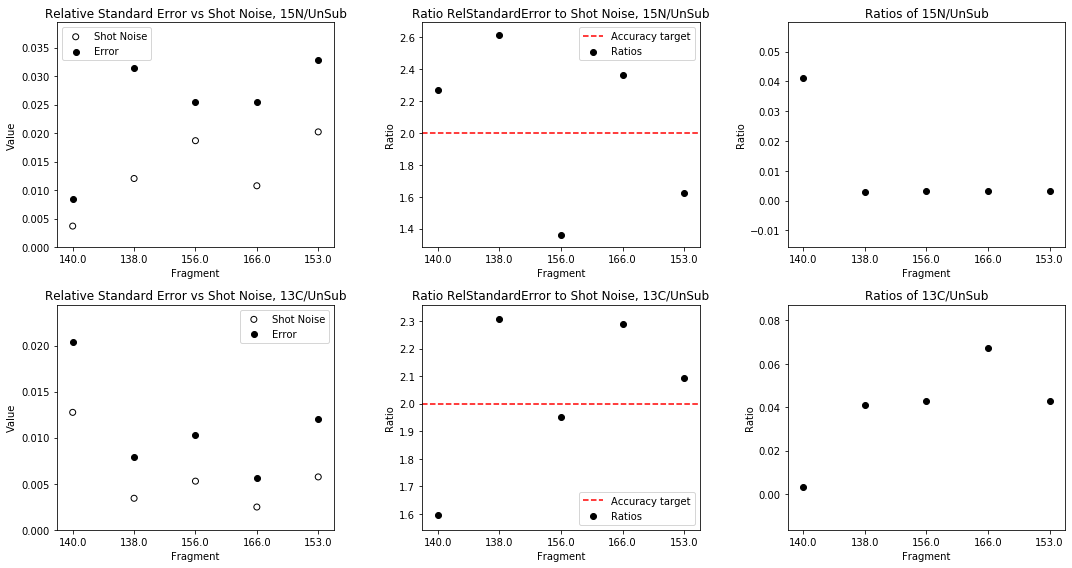

In [65]:
inputStandardFile = "/Users/sarahzeichner/Documents/Caltech/2019-2020/Research/Orbitrap Data Processing Script/AA_std_2_04.xlsx"
outputPath = "/Users/sarahzeichner/Documents/Caltech/2019-2020/Research/Orbitrap Data Processing Script/outputtest.csv"
isotopeList = ['UnSub','15N','13C']
gc_elution_on = True
peakTimeFrames = [(5.65,5.85), (6.82,7.62), (9.74,10.04), (10.00,10.30), (13.74,14.04)]
omitRatios = []
peaks = _importPeaksFromFTStatFile(inputStandardFile)
pandas = _convertToPandasDataFrame(peaks)
Merged = _combineSubstituted(pandas, None, gc_elution_on, peakTimeFrames, 2, isotopeList, 0.10, outputPath)
Output = _calcRawFileOutput(Merged, gc_elution_on, isotopeList, omitRatios)